# Data Cleaning

In [1]:
!pwd

/home/haj013/teams/project-team-67


In [2]:
# import kagglehub
# from kagglehub import KaggleDatasetAdapter

In [3]:
# car_plate_detection_path = kagglehub.dataset_download('andrewmvd/car-plate-detection')
car_plate_detection_path = 'archive'

In [4]:
import numpy as np
import pandas as pd

In [5]:
base_path = 'archive'

In [6]:
import os
import xml.etree.ElementTree as ET

# Define paths
annotation_folder = os.path.join(base_path, "annotations")

# List to store data
data = []

# Function to parse XML and extract relevant information
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find("filename").text
    width = int(root.find(".//size/width").text)
    height = int(root.find(".//size/height").text)
    depth = int(root.find(".//size/depth").text)

    obj = root.find(".//object")
    obj_name = obj.find("name").text
    xmin = int(obj.find(".//bndbox/xmin").text)
    ymin = int(obj.find(".//bndbox/ymin").text)
    xmax = int(obj.find(".//bndbox/xmax").text)
    ymax = int(obj.find(".//bndbox/ymax").text)

    return [filename, width, height, depth, obj_name, xmin, ymin, xmax, ymax]

# Process all annotation files
for xml_file in os.listdir(annotation_folder):
    if xml_file.endswith(".xml"):
        xml_path = os.path.join(annotation_folder, xml_file)
        data.append(parse_xml(xml_path))

# Create DataFrame
columns = ["filename", "width", "height", "depth", "object_name", "xmin", "ymin", "xmax", "ymax"]
df = pd.DataFrame(data, columns=columns)

# Save to CSV
# df.to_csv(os.path.join(base_path, "annotations.csv"), index=False)

# Display DataFrame
print(df.head())

      filename  width  height  depth object_name  xmin  ymin  xmax  ymax
0  Cars175.png    600     450      3     licence   295   237   456   367
1  Cars262.png    400     301      3     licence   243   184   285   205
2   Cars86.png    586     331      3     licence   332   176   447   204
3  Cars346.png    400     246      3     licence    91   185   197   217
4  Cars397.png    400     299      3     licence   144   169   216   212


In [7]:
df.drop(['depth', 'object_name', 'height', 'width'], axis=1, inplace=True)

In [8]:
df.head()

filename  xmin  ymin  xmax  ymax
0  Cars175.png   295   237   456   367
1  Cars262.png   243   184   285   205
2   Cars86.png   332   176   447   204
3  Cars346.png    91   185   197   217
4  Cars397.png   144   169   216   212

## Save CSV

In [9]:
# df.to_csv('/kaggle/working/annotations.csv', index=False)
df.to_csv('archive/annotations.csv', index=False)

# Data Preprocessing

## Importing libraries

In [10]:
import os
import random
import pandas as pd
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

2025-11-23 04:06:05.118471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-23 04:06:05.118526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-23 04:06:05.120017: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-23 04:06:05.128016: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Creating the Custom Dataset class

In [11]:
class NumberPlateDataset(Dataset):
    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            images_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        # Get the row corresponding to the idx
        row = self.data_frame.iloc[idx]
        img_name = row['filename']  
        
        # Load image
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        # Get bounding box coordinates (e.g., x_min, y_min, x_max, y_max)
        bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        bbox = torch.tensor(bbox, dtype=torch.float32).unsqueeze(0)   #1 class

        # For transfer learning, if you have only one class (number plate), you could use label 1.
        # Adjust accordingly if you have more classes.
        labels = torch.tensor([1], dtype=torch.int64)
        
        # Apply any transformations to the image (if provided)
        if self.transform:
            image = self.transform(image)
        
        #target dictionary
        target = {
            'boxes': bbox,
            'labels': labels
        }
        
        return image, target

In [12]:
#paths
# base_path = '/kaggle/input/car-plate-detection'
# csv_file = '/kaggle/working/annotations.csv'

base_path = 'archive'
csv_file = 'archive/annotations.csv'

img_dir = os.path.join(base_path, "images")

In [13]:
#transform for each image
transform = transforms.Compose([
    transforms.ToTensor()
])

## Train test split and creating dataloader

Made an 80-20 train test split

In [14]:
# Suppose dataset is an instance of your custom dataset class
dataset = NumberPlateDataset(csv_file, img_dir, transform)

# Define the split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=4, 
    shuffle=True, 
    collate_fn=collate_fn
)

val_loader = DataLoader(
    test_dataset, 
    batch_size=4, 
    shuffle=False, 
    collate_fn=collate_fn
)

In [15]:
# Test dataset loading
sample_image, sample_target = dataset[0]

print("Image shape:", sample_image.shape)  # Should be (3, H, W)
print("Bounding Boxes:", sample_target["boxes"])  # Should be a tensor with shape (N, 4)
print("Labels:", sample_target["labels"])  # Should be a tensor with 1 label (number plate)

Image shape: torch.Size([3, 450, 600])
Bounding Boxes: tensor([[295., 237., 456., 367.]])
Labels: tensor([1])


In [16]:
# Get a batch from DataLoader
batch = next(iter(train_loader))

print("Batch size:", len(batch[0]))  # Should match batch_size (e.g., 4)
print("First image shape:", batch[0][0].shape)  # Should be (3, H, W)
print("First target boxes:", batch[1][0]["boxes"])  # Should be tensor([[xmin, ymin, xmax, ymax]])

Batch size: 4
First image shape: torch.Size([3, 332, 400])
First target boxes: tensor([[156., 182., 255., 208.]])


In [17]:
# Load the pre-trained Faster R-CNN ResNet50 FPN v2 model
model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
#pretrained=True is for old versions so using weights

# Model Training

## Base Model Architecture

#### FasterRCNN with ResNet50 FPN V2
* RCNN Transform
* ResNet50 backbone with FPN
  * Resnet50
  * Feature Pyramid Network
* Region Proposal Network
  * Anchor Generator
  * RPN Head
* ROI Head
  * Multi scale ROI align
  * Fast RCNN ConvFC head
  * Fast RCNN Predictor
    * classification score -> should be 2 (1 for number plates 1 for background)
    * bbox prediction -> coordinates of bbox

In [18]:
# Count the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal number of parameters: {total_params}")
print(f"Total number of trainable parameters: {trainable_params}")


Total number of parameters: 43712278
Total number of trainable parameters: 43486934


In [19]:
print('Old predictor:')
print(model.roi_heads.box_predictor)

Old predictor:
FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)


## Updating the fastrcnn predictor

In [20]:
# Get the number of input features for the classifier (the final fully connected layer)
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Define the number of classes (1 number plate + background)
num_classes = 2

# Replace the pre-trained predictor with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Print model's ROI head to verify changes
print("Updated ROI Head Predictor:")
print(model.roi_heads.box_predictor)

Updated ROI Head Predictor:
FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)


In [21]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#transfers the model’s parameters to the selected device, ensuring all computations occur there
model.to(device)

Using device: cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

## Freezing the backbone model

will fine tune the rest of the model

In [22]:
# Freeze the backbone (ResNet50 + FPN)
for param in model.backbone.parameters():
    param.requires_grad = False

# can freeze the RPN later if needed:
# for param in model.rpn.parameters():
#     param.requires_grad = False

# The ROI head, including the new box predictor, remains trainable.

In [23]:
# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Calculate number of trainable parameters (i.e., those that require gradients)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total number of parameters:", total_params)
print("Number of trainable parameters:", trainable_params)

Total number of parameters: 43256153
Number of trainable parameters: 16401689


In [24]:
# Set up the optimizer and learning rate scheduler.
# Only parameters with requires_grad=True will be updated.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [25]:
# -------------------------------
# Helper Function to Compute IoU
# -------------------------------
def compute_iou(boxA, boxB):
    """
    Computes Intersection over Union (IoU) between two bounding boxes.
    Each box is defined as [x_min, y_min, x_max, y_max].
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)
    inter_area = inter_width * inter_height
    
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    iou = inter_area / float(boxA_area + boxB_area - inter_area + 1e-6)
    return iou

## Training loop

In [26]:
# -------------------------------
# Training Loop with Evaluation
# -------------------------------
# Define evaluation thresholds
score_threshold = 0.5
iou_threshold = 0.5

num_epochs = 10
best_val_loss = float('inf')

# Lists to store epoch-level metrics for plotting later
epoch_train_losses = []
epoch_val_losses = []
epoch_val_avg_iou = []
epoch_val_detection_rate = []  # Approximated as (TP / total images)

for epoch in range(num_epochs):
    # ----- Training Phase -----
    model.train()  # Ensure model is in training mode
    train_metric_sums = defaultdict(float)
    num_train_batches = 0
    train_loss = 0.0
    
    train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", unit="batch")
    for images, targets in train_progress:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)  # Model returns a loss dictionary in training mode
        total_loss = sum(loss for loss in loss_dict.values())
        
        # Accumulate loss metrics
        for key, loss in loss_dict.items():
            train_metric_sums[key] += loss.item()
        train_loss += total_loss.item()
        num_train_batches += 1
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        train_progress.set_postfix(loss=f"{total_loss.item():.4f}")
    
    avg_train_loss = train_loss / num_train_batches
    epoch_train_losses.append(avg_train_loss)
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}] Training Loss: {avg_train_loss:.4f}")
    for metric, value in train_metric_sums.items():
        print(f"  {metric}: {value / num_train_batches:.4f}")
    
    # ----- Validation Phase -----
    # We need to compute both the loss and the detection metrics.
    # For loss computation, we use training mode (which expects targets).
    # For predictions, we temporarily switch to eval mode.
    model.train()  # Remains in training mode for loss computation
    val_metric_sums = defaultdict(float)
    num_val_batches = 0
    val_loss = 0.0
    
    # For additional evaluation metrics:
    total_iou = 0.0
    total_images = 0
    true_positive_count = 0  # Count images with a "good" detection
    
    with torch.no_grad():
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", unit="batch")
        for images, targets in val_progress:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Compute loss in training mode (expects targets)
            loss_dict = model(images, targets)
            total_loss_batch = sum(loss for loss in loss_dict.values())
            val_loss += total_loss_batch.item()
            num_val_batches += 1
            
            # Now, switch to eval mode temporarily to get predictions
            model.eval()
            outputs = model(images)  # In inference mode, outputs is a list of dicts (one per image)
            model.train()  # Switch back to training mode for consistency
            
            # Evaluate detection performance for each image in the batch
            for output, target in zip(outputs, targets):
                # Assuming one ground truth box per image
                gt_box = target["boxes"][0].cpu().numpy()
                pred_boxes = output["boxes"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()
                if len(pred_boxes) > 0:
                    max_index = pred_scores.argmax()
                    pred_box = pred_boxes[max_index]
                    pred_score = pred_scores[max_index]
                    iou = compute_iou(pred_box, gt_box)
                else:
                    iou = 0.0
                    pred_score = 0.0
                total_iou += iou
                total_images += 1
                # Count as a true positive if thresholds are met
                if pred_score >= score_threshold and iou >= iou_threshold:
                    true_positive_count += 1
                    
            val_progress.set_postfix(loss=f"{total_loss_batch.item():.4f}")
    
    avg_val_loss = val_loss / num_val_batches
    epoch_val_losses.append(avg_val_loss)
    
    # Compute average IoU and detection rate (as an approximation for AP)
    avg_iou = total_iou / total_images if total_images > 0 else 0.0
    detection_rate = true_positive_count / total_images if total_images > 0 else 0.0
    
    epoch_val_avg_iou.append(avg_iou)
    epoch_val_detection_rate.append(detection_rate)
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.4f}")
    for metric, value in val_metric_sums.items():
        print(f"  {metric}: {value / num_val_batches:.4f}")
    print(f"  Average IoU: {avg_iou:.4f}")
    print(f"  Detection Rate: {detection_rate:.4f}")
    
    # Save best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model.")
    
    scheduler.step()

Epoch 1/10 [Train]:  60%|█████▉    | 52/87 [00:31<00:21,  1.63batch/s, loss=0.1320]


KeyboardInterrupt: 

## Plot Metrics

In [ ]:
# -------------------------------
# Plotting Metrics After Training
# -------------------------------
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_train_losses, 'b-o', label='Train Loss')
plt.plot(epochs, epoch_val_losses, 'r-o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

# Plot IoU and Detection Rate
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_val_avg_iou, 'g-o', label='Avg IoU')
plt.plot(epochs, epoch_val_detection_rate, 'm-o', label='Detection Rate')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation IoU & Detection Rate Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Testing on random images

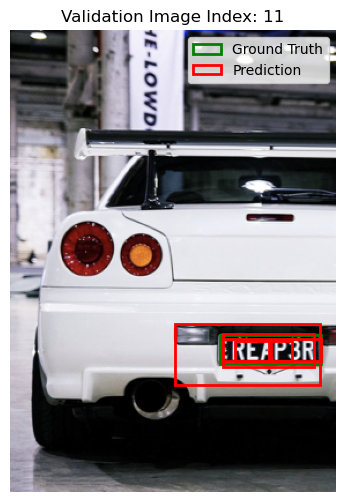

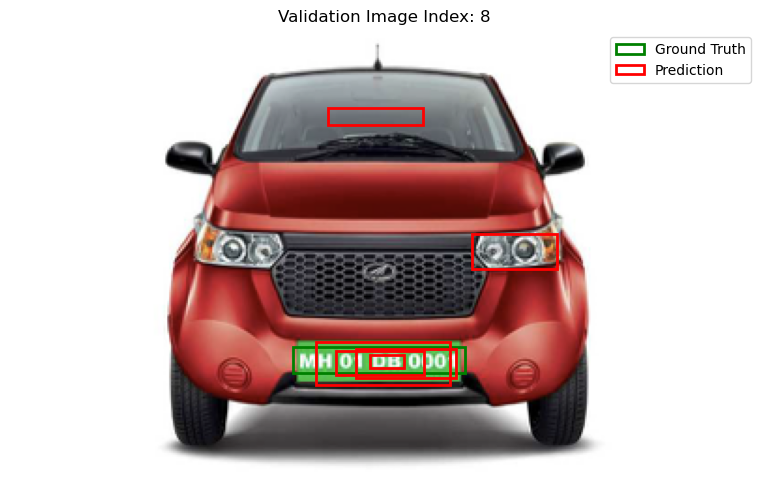

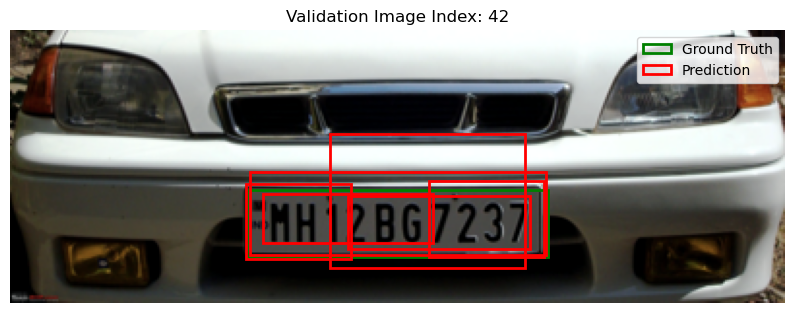

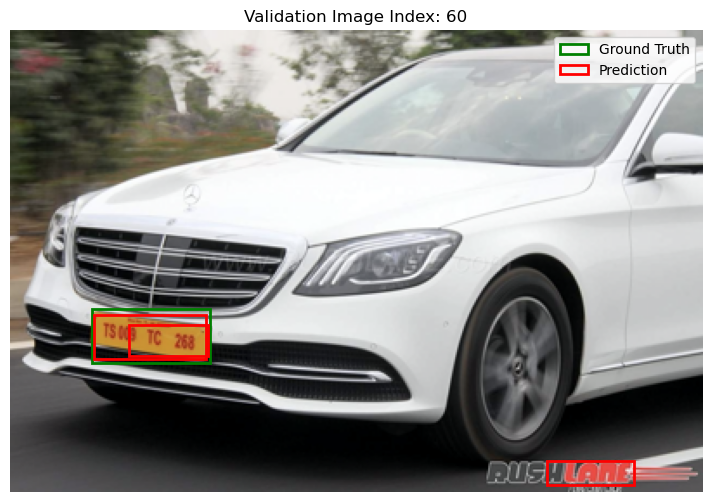

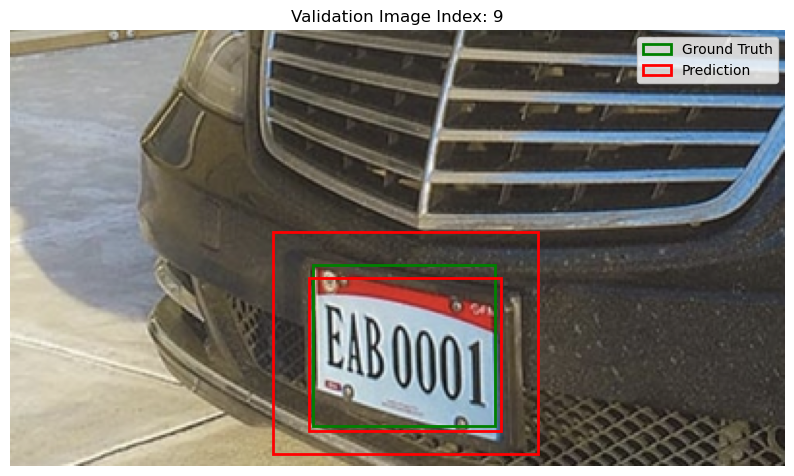

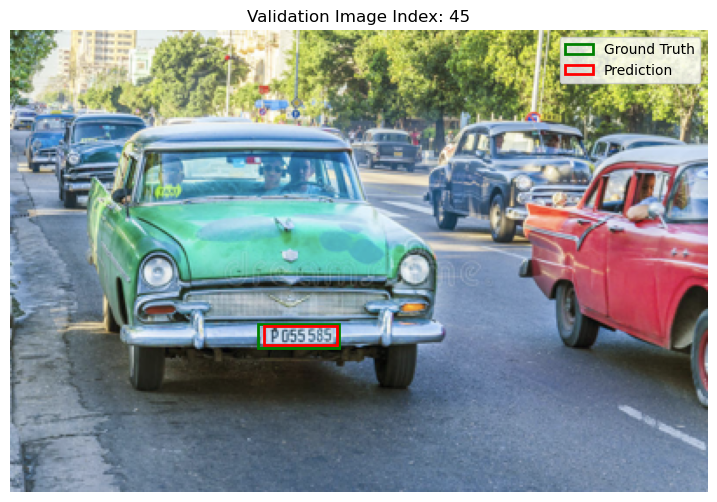

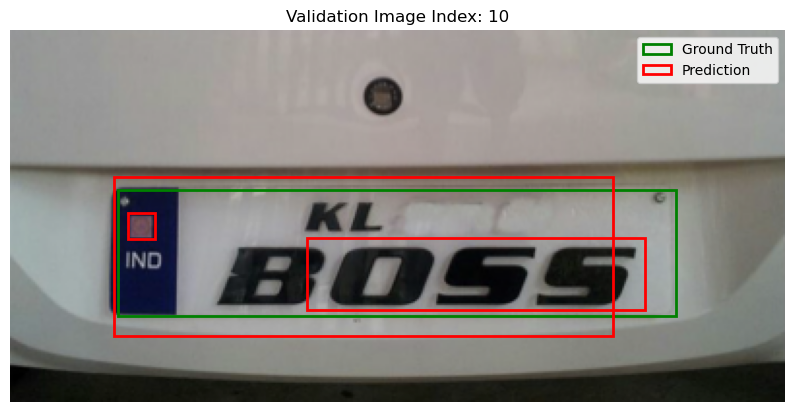

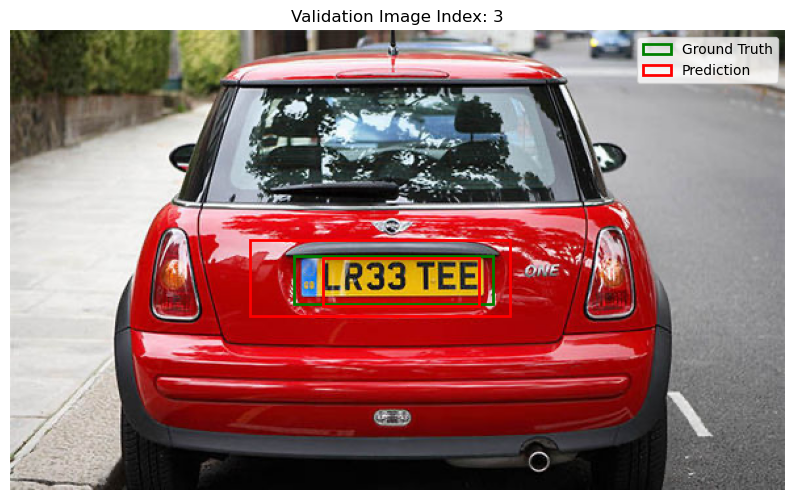

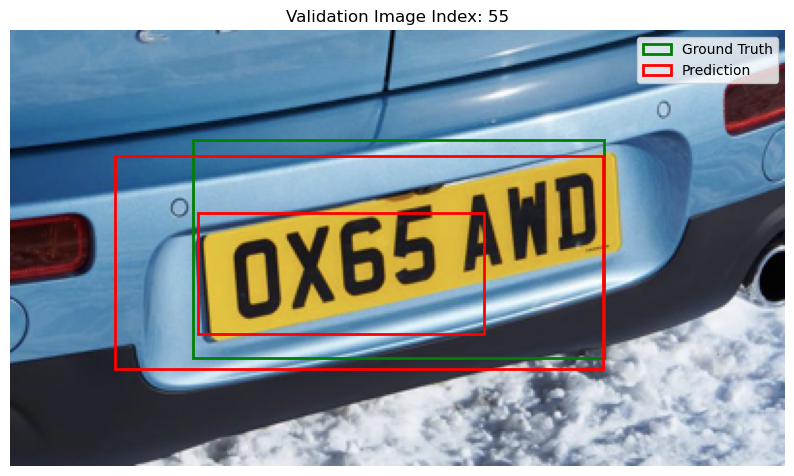

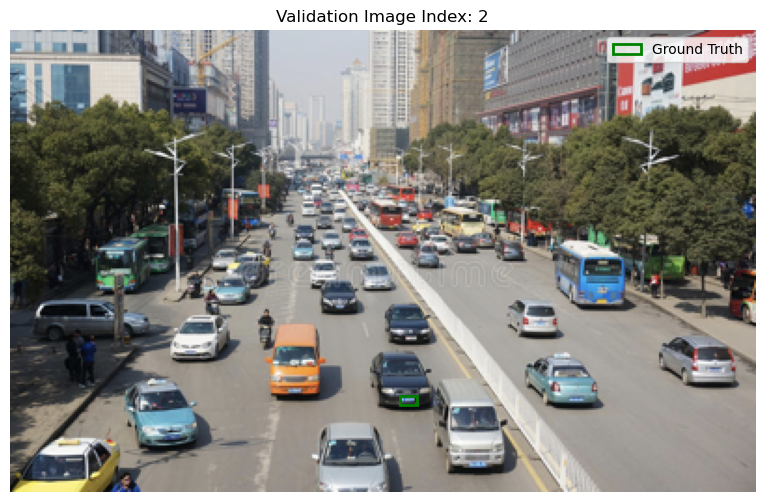

In [27]:
# Number of random images to visualize
num_samples = 10
# Randomly sample indices from the validation dataset
sample_indices = random.sample(range(len(test_dataset)), num_samples)

# Set model to evaluation mode for inference
model.eval()

for idx in sample_indices:
    # Get image and ground truth target from the validation dataset
    image, target = test_dataset[idx]
    
    # If image is a tensor, convert it to a PIL image for display
    if torch.is_tensor(image):
        # Assuming the tensor is in [0,1] range and of shape (C, H, W)
        image_disp = F.to_pil_image(image)
    else:
        image_disp = image

    # Run inference on a single image; model expects a list of images
    with torch.no_grad():
        output = model([image.to(device)])[0]  # output is a dict for this image

    # Create the plot
    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.imshow(image_disp)

    # Plot ground truth bounding box (in green)
    gt_box = target["boxes"][0].cpu().numpy()  # Assuming one ground truth box per image
    gt_rect = plt.Rectangle((gt_box[0], gt_box[1]),
                            gt_box[2] - gt_box[0],
                            gt_box[3] - gt_box[1],
                            fill=False, edgecolor='green', linewidth=2, label='Ground Truth')
    ax.add_patch(gt_rect)

    # Plot predicted bounding boxes (in red) for predictions with a score above a threshold (e.g., 0.5)
    pred_boxes = output["boxes"].cpu().numpy()
    pred_scores = output["scores"].cpu().numpy()
    for box, score in zip(pred_boxes, pred_scores):
        if score < 0.5:
            continue  # Skip predictions with low confidence
        pred_rect = plt.Rectangle((box[0], box[1]),
                                  box[2] - box[0],
                                  box[3] - box[1],
                                  fill=False, edgecolor='red', linewidth=2, label='Prediction')
        ax.add_patch(pred_rect)

    # Remove duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys())

    plt.title(f"Validation Image Index: {idx}")
    plt.axis('off')
    plt.show()

In [28]:
torch.save(model.state_dict(), "final_model.pth", _use_new_zipfile_serialization=True)

Initializing OCR reader...
Initialization complete!

Example 1: Single Image Recognition
Plate #1: 661F25 (Detection: 0.860, OCR: 0.018)
Plate #2: KLGID (Detection: 0.754, OCR: 0.232)
Plate #3: [1[12555 (Detection: 0.694, OCR: 0.301)
Plate #4: KLGIBAZ5 (Detection: 0.601, OCR: 0.160)
Plate #5: [42515 (Detection: 0.532, OCR: 0.270)


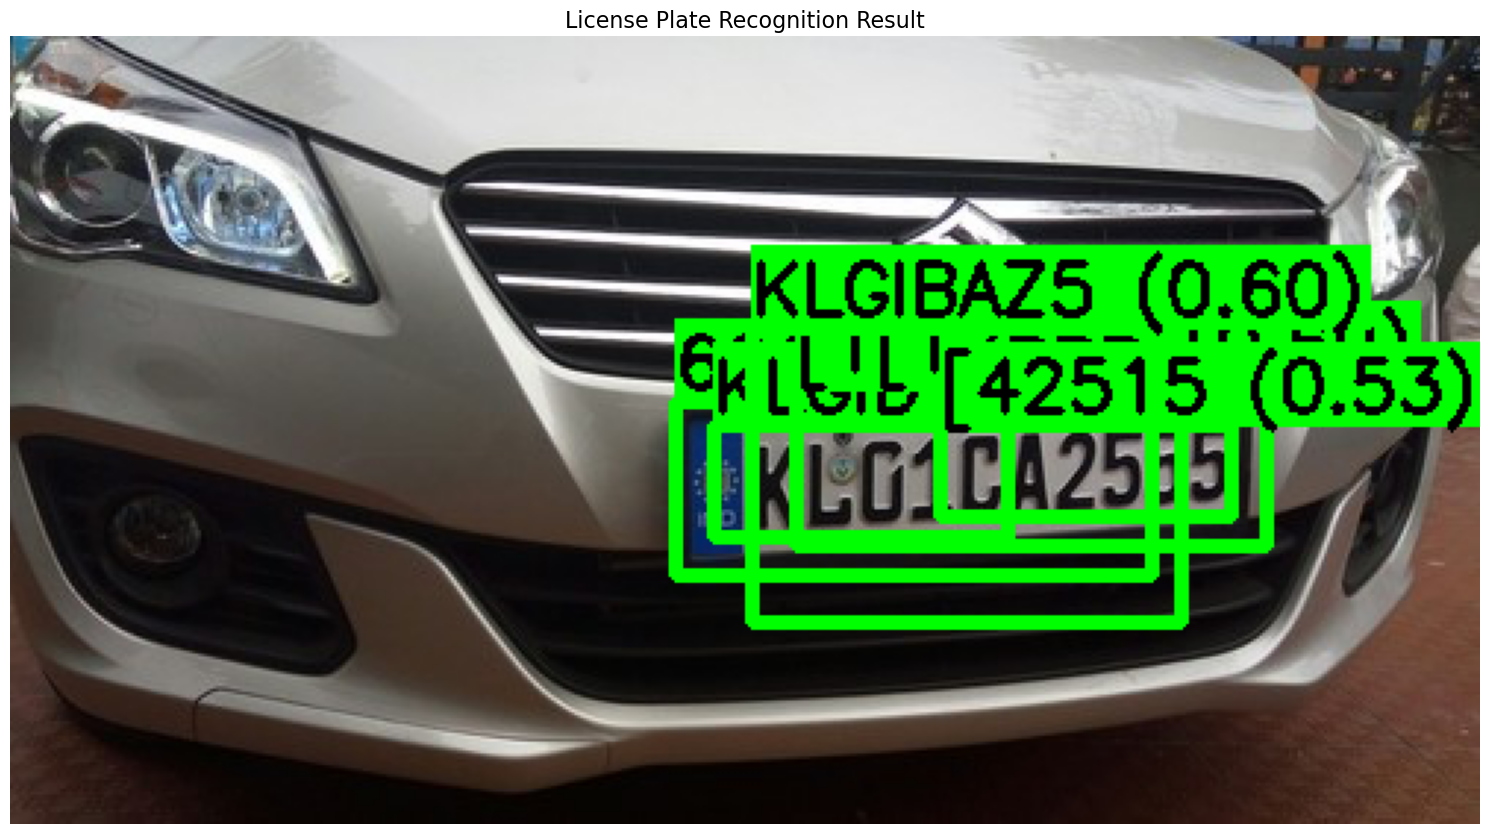


Recognition Results:
--------------------------------------------------
Plate 1:
  Plate Number: 661F25
  Detection Confidence: 0.860
  OCR Confidence: 0.018

Plate 2:
  Plate Number: KLGID
  Detection Confidence: 0.754
  OCR Confidence: 0.232

Plate 3:
  Plate Number: [1[12555
  Detection Confidence: 0.694
  OCR Confidence: 0.301

Plate 4:
  Plate Number: KLGIBAZ5
  Detection Confidence: 0.601
  OCR Confidence: 0.160

Plate 5:
  Plate Number: [42515
  Detection Confidence: 0.532
  OCR Confidence: 0.270


Example 2: Batch Recognition

Processing image 1/5: archive/images/Cars41.png
--------------------------------------------------
Plate #1: JNTZUBG (Detection: 0.889, OCR: 0.166)
Plate #2: VNI< (Detection: 0.580, OCR: 0.140)


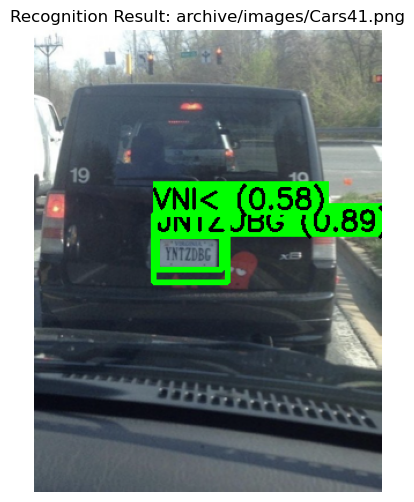


Processing image 2/5: archive/images/Cars163.png
--------------------------------------------------
Plate #1: l33] (Detection: 0.869, OCR: 0.024)
Plate #2: R33TEE (Detection: 0.664, OCR: 0.964)


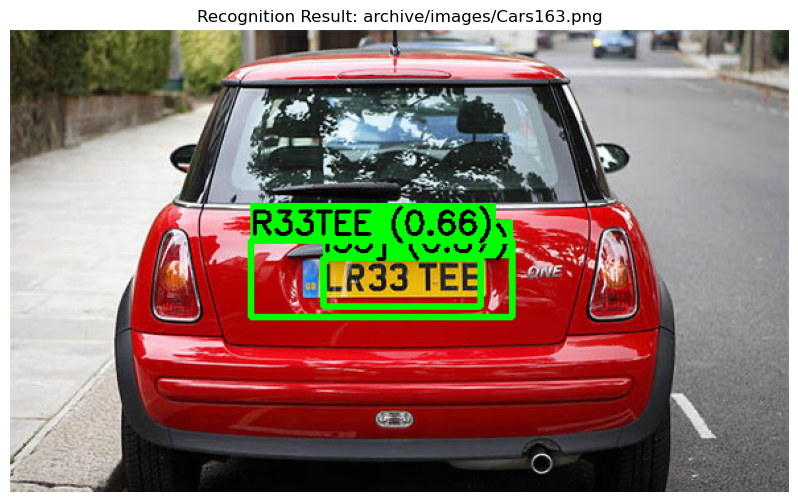


Processing image 3/5: archive/images/Cars274.png
--------------------------------------------------
Plate #1: 『吧 (Detection: 0.774, OCR: 0.000)


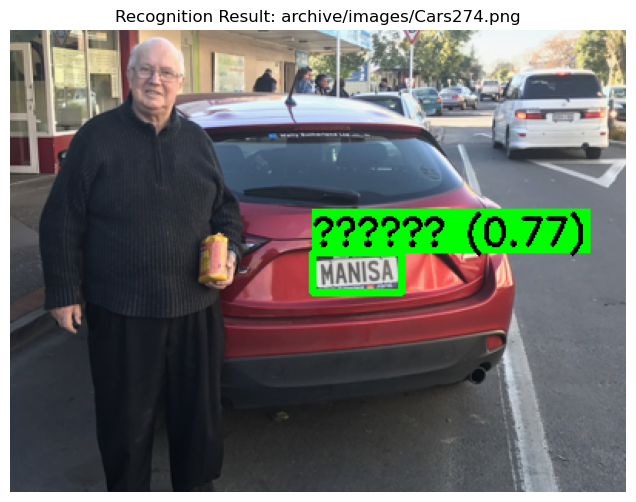


Processing image 4/5: archive/images/Cars90.png
--------------------------------------------------


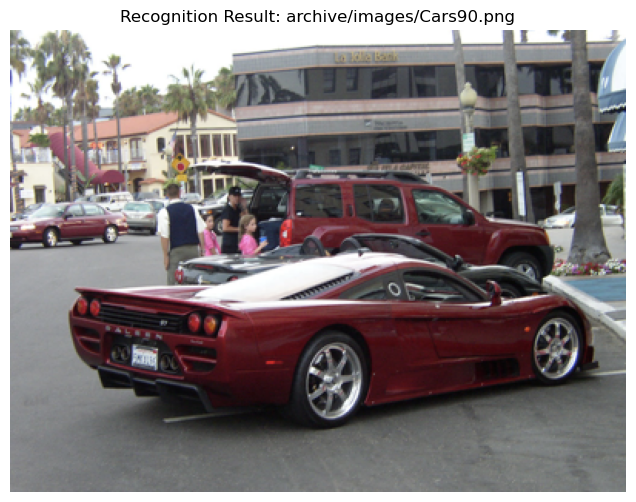


Processing image 5/5: archive/images/Cars350.png
--------------------------------------------------


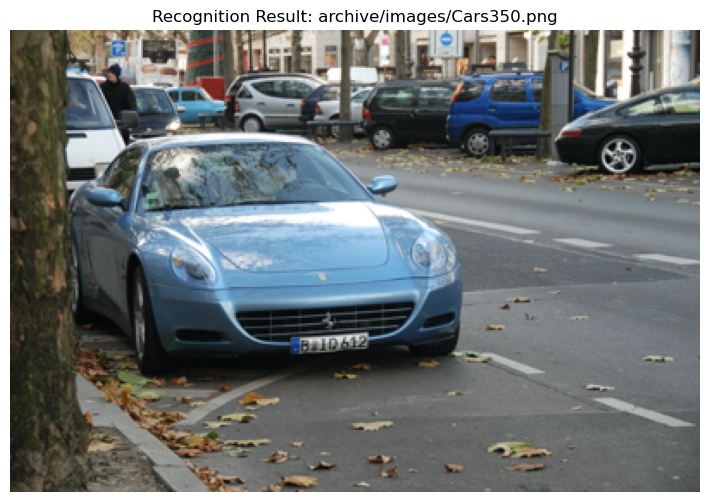


All results saved to: license_plate_results.csv
Total 5 plates recognized

Example 3: Recognition Statistics
Total Recognitions: 5
Average Detection Confidence: 0.755
Average OCR Confidence: 0.259

All Recognized Plate Numbers:
  1. JNTZUBG
  2. VNI<
  3. l33]
  4. R33TEE
  5. 『吧

All functions loaded successfully!

Usage Instructions:
1. Single recognition: recognize_license_plate(image_path, model, device, transform)
2. Batch recognition: batch_recognize(image_paths, model, device, transform)
3. Image preprocessing: preprocess_plate_image(plate_img)


In [29]:
"""
Simplified License Plate Recognition Code - Ready to Add to Notebook

Just 3 Steps:
1. Install EasyOCR
2. Copy this code
3. Run and test
"""

# ============================================
# Step 1: Install Dependencies (Run in Notebook)
# ============================================
# !pip install easyocr

# ============================================
# Step 2: Import Libraries and Initialize OCR
# ============================================
import easyocr
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

# Initialize OCR reader (will download model on first run)
print("Initializing OCR reader...")
reader = easyocr.Reader(['ch_sim', 'en'], gpu=True)  # Chinese + English
print("Initialization complete!")

# ============================================
# Step 3: Define Recognition Functions
# ============================================

def recognize_license_plate(image_path, model, device, transform, confidence_threshold=0.5):
    """
    Complete license plate recognition pipeline
    
    Args:
        image_path: Path to image file
        model: Trained Faster R-CNN model
        device: 'cuda' or 'cpu'
        transform: Image transformation
        confidence_threshold: Detection confidence threshold
    
    Returns:
        results: List of recognition results
        annotated_image: Image with annotations
    """
    
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Cannot read image {image_path}")
        return [], None
    
    # Prepare model input
    img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    
    # License plate detection
    model.eval()
    with torch.no_grad():
        predictions = model(img_tensor)
    
    # Get detection results
    boxes = predictions[0]['boxes'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    
    # Store recognition results
    results = []
    
    # Process each detected license plate
    for idx, (box, score) in enumerate(zip(boxes, scores)):
        if score > confidence_threshold:
            # Crop license plate region
            xmin, ymin, xmax, ymax = map(int, box)
            
            # Ensure coordinates are within bounds
            h, w = image.shape[:2]
            xmin = max(0, xmin)
            ymin = max(0, ymin)
            xmax = min(w, xmax)
            ymax = min(h, ymax)
            
            plate_img = image[ymin:ymax, xmin:xmax]
            
            # Skip regions that are too small
            if plate_img.shape[0] < 10 or plate_img.shape[1] < 10:
                continue
            
            # OCR recognition
            try:
                ocr_results = reader.readtext(plate_img)
                
                if ocr_results:
                    # Get result with highest confidence
                    best_result = max(ocr_results, key=lambda x: x[2])
                    plate_text = best_result[1].replace(" ", "").replace("-", "")
                    ocr_confidence = best_result[2]
                    
                    # Save result
                    results.append({
                        'plate_number': plate_text,
                        'detection_score': float(score),
                        'ocr_confidence': float(ocr_confidence),
                        'bbox': box.tolist()
                    })
                    
                    # Draw bounding box and text on image
                    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
                    
                    # Add text label
                    label = f"{plate_text} ({score:.2f})"
                    
                    # Calculate text background
                    (text_w, text_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                    cv2.rectangle(image, (xmin, ymin - text_h - 10), 
                                (xmin + text_w, ymin), (0, 255, 0), -1)
                    
                    # Add text
                    cv2.putText(image, label, (xmin, ymin - 5),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
                    
                    print(f"Plate #{idx+1}: {plate_text} (Detection: {score:.3f}, OCR: {ocr_confidence:.3f})")
                    
            except Exception as e:
                print(f"Error recognizing plate #{idx+1}: {e}")
                continue
    
    return results, image


def batch_recognize(image_paths, model, device, transform, confidence_threshold=0.5):
    """
    Batch recognition for multiple images
    
    Args:
        image_paths: List of image file paths
        Other args same as recognize_license_plate
    
    Returns:
        all_results: Recognition results for all images
    """
    all_results = []
    
    for idx, img_path in enumerate(image_paths):
        print(f"\nProcessing image {idx+1}/{len(image_paths)}: {img_path}")
        print("-" * 50)
        
        results, annotated_img = recognize_license_plate(
            img_path, model, device, transform, confidence_threshold
        )
        
        # Save results for each image
        for result in results:
            result['image_path'] = img_path
            all_results.append(result)
        
        # Display result image
        if annotated_img is not None:
            plt.figure(figsize=(12, 6))
            plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f'Recognition Result: {img_path}')
            plt.show()
    
    return all_results


# ============================================
# Step 4: Usage Examples
# ============================================

# Example 1: Recognize single image
print("\n" + "="*60)
print("Example 1: Single Image Recognition")
print("="*60)

test_image = os.path.join(base_path, 'images/Cars0.png')
results, result_image = recognize_license_plate(
    test_image, 
    model,  # Your trained model
    device, 
    transform,
    confidence_threshold=0.5
)

# Display results
if result_image is not None:
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('License Plate Recognition Result', fontsize=16)
    plt.tight_layout()
    plt.show()

# Print recognition results
print("\nRecognition Results:")
print("-" * 50)
for i, result in enumerate(results):
    print(f"Plate {i+1}:")
    print(f"  Plate Number: {result['plate_number']}")
    print(f"  Detection Confidence: {result['detection_score']:.3f}")
    print(f"  OCR Confidence: {result['ocr_confidence']:.3f}")
    print()


# Example 2: Batch recognition for multiple images
print("\n" + "="*60)
print("Example 2: Batch Recognition")
print("="*60)

# Get all test images
image_folder = os.path.join(base_path, 'images')
test_images = [os.path.join(image_folder, f) for f in os.listdir(image_folder)[:5]]  # Test first 5 images

all_results = batch_recognize(
    test_images,
    model,
    device,
    transform,
    confidence_threshold=0.5
)

# Save results to CSV
import pandas as pd
df = pd.DataFrame(all_results)
df.to_csv('license_plate_results.csv', index=False)
print(f"\nAll results saved to: license_plate_results.csv")
print(f"Total {len(all_results)} plates recognized")


# Example 3: Statistical analysis
print("\n" + "="*60)
print("Example 3: Recognition Statistics")
print("="*60)

if len(all_results) > 0:
    avg_detection = sum(r['detection_score'] for r in all_results) / len(all_results)
    avg_ocr = sum(r['ocr_confidence'] for r in all_results) / len(all_results)
    
    print(f"Total Recognitions: {len(all_results)}")
    print(f"Average Detection Confidence: {avg_detection:.3f}")
    print(f"Average OCR Confidence: {avg_ocr:.3f}")
    
    # Display all recognized plate numbers
    print("\nAll Recognized Plate Numbers:")
    for i, result in enumerate(all_results):
        print(f"  {i+1}. {result['plate_number']}")


# ============================================
# Additional Feature: Image Preprocessing (Improve Accuracy)
# ============================================

def preprocess_plate_image(plate_img):
    """
    Preprocess cropped plate image to improve recognition accuracy
    """
    # Convert to grayscale
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    
    # Denoise
    denoised = cv2.fastNlMeansDenoising(gray, h=10)
    
    # Adaptive thresholding
    binary = cv2.adaptiveThreshold(
        denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Morphological operations (remove small noise)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    return cleaned


# If you need to use preprocessing, modify this line in the recognition function:
# plate_img = preprocess_plate_image(plate_img)
# ocr_results = reader.readtext(plate_img)

print("\n" + "="*60)
print("All functions loaded successfully!")
print("="*60)
print("\nUsage Instructions:")
print("1. Single recognition: recognize_license_plate(image_path, model, device, transform)")
print("2. Batch recognition: batch_recognize(image_paths, model, device, transform)")
print("3. Image preprocessing: preprocess_plate_image(plate_img)")
